In [1]:
import numpy as np
import pandas as pd
import timeit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn import decomposition
from sklearn import random_projection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [2]:
def line_plot(title, x_label, y_label, X, Y, lines, colors):
    plt.figure()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()
    for i in range(len(Y)):
        plt.plot(X, Y[i], label=lines[i], color=colors[i])
    plt.legend()
    plt.show()

In [3]:
def encode_categories(df, col):
    ord_enc = OrdinalEncoder()
    df[col] = ord_enc.fit_transform(df[[col]])

In [45]:
# Data Processing
student_data = pd.read_csv("StudentPerformancePor.csv", sep=';')
# display(student_data.head())
    
student_data['total_score'] = student_data.iloc[:, -3:-1].sum(axis=1)
student_data.loc[student_data['total_score'] > student_data['total_score'].mean(), 'performance'] = 1
student_data.loc[student_data['total_score'] <= student_data['total_score'].mean(), 'performance'] = 0

display(student_data.head())
    
student_features = student_data.iloc[:,:30]

student_performance = student_data.iloc[:,-1]
    
col_list = ['address','sex','famsize','Pstatus','guardian','schoolsup',\
            'famsup','paid','activities','higher','internet', 'school', \
            'Mjob', 'Fjob', 'nursery', 'absences', 'failures', 'reason', 'romantic']
for i in col_list:
    encode_categories(student_features, i)
    
# display(student_features.head())
    
# Split Data for training and testing
x_train, x_test, y_train, y_test = train_test_split(student_features, student_performance, \
                                                        test_size=0.2, random_state=2)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,Dalc,Walc,health,absences,G1,G2,G3,total_score,performance
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,4,0,11,11,11,0.0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,1,1,3,2,9,11,11,20,0.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,2,3,3,6,12,13,12,25,1.0
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,1,1,5,0,14,14,14,28,1.0
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,1,2,5,0,11,13,13,24,1.0


In [5]:
# Method for ANN with Dimension Reduction Score 

def ann_score(model, x_train, x_test, y_train=y_train, y_test=y_test):

    model.fit(x_train, y_train)
    train_label = model.predict(x_train)
    test_label = model.predict(x_test)

    train_score = accuracy_score(train_label, y_train)
    test_score = accuracy_score(test_label, y_test)

    return [train_score, test_score]

C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  f"KMeans is known to have a memory leak on Windows "


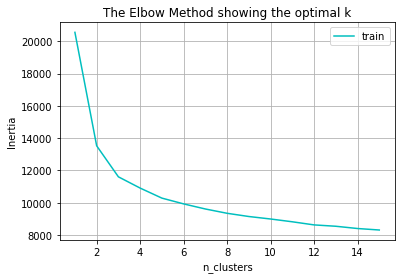

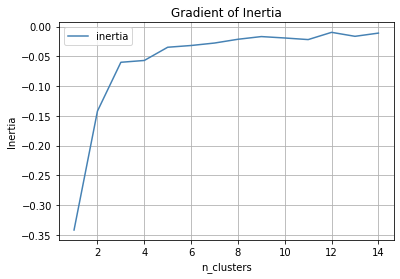

In [6]:
# ====================== K MEANS on different k (WWS) ===========================

def kmeans_inertia(x_train, x_test, kmax=15):
    n_clusters = []
    inertias = []

    for k in range(1,kmax+1):
        n_clusters.append(k)
        kmeans = KMeans(n_clusters=k, random_state=2)
        kmeans.fit(x_train)
        inertias.append(kmeans.inertia_)
    
    # Plot
    line_plot(title="The Elbow Method showing the optimal k", x_label='n_clusters', y_label='Inertia', \
             X=n_clusters, Y=[inertias], \
             lines=['train'], colors = ['c'])
    
    return inertias

inertias = kmeans_inertia(x_train, x_test)

# Plot Gradient of Inertia
inertia_gradient = []
for i in range(len(inertias)-1):
    inertia_gradient.append((inertias[i+1]-inertias[i])/inertias[i])
# Plot
line_plot(title="Gradient of Inertia", x_label='n_clusters', y_label='Inertia', \
          X=[k for k in range(1, 15)], Y=[inertia_gradient], \
          lines=['inertia'], colors = ['steelblue'])

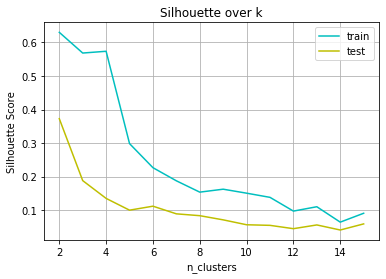

In [7]:
# ====================== K MEANS on different k (Sil) ===========================

from sklearn.metrics import silhouette_score

sil_train = []
sil_test = []
n_clusters = []
kmax = 15

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    n_clusters.append(k)
    kmeans = KMeans(n_clusters = k, random_state=2)
    kmeans.fit(x_train)
    df_train = kmeans.transform(x_train)
    train_labels = kmeans.labels_
    sil_train.append(silhouette_score(df_train, train_labels, metric = 'euclidean', random_state=2))
    
    test_labels = kmeans.predict(x_test)
    sil_test.append(silhouette_score(x_test, test_labels, metric = 'euclidean', random_state=2))
    
# Plot
line_plot(title="Silhouette over k", x_label='n_clusters', y_label='Silhouette Score', \
          X=n_clusters, Y=[sil_train, sil_test], \
          lines=['train','test'], colors = ['c','y'])

<function matplotlib.pyplot.show(*args, **kw)>

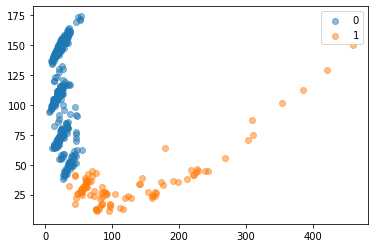

In [8]:
# ====================== K MEANS ===========================

kmeans = KMeans(n_clusters=2, random_state=2)
kmeans.fit(x_train)
df_train = kmeans.transform(x_train)**2
km2_label = kmeans.labels_
centroids = kmeans.cluster_centers_

for i in np.unique(km2_label):
    plt.scatter(df_train[km2_label == i, 0], df_train[km2_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show

train score 0.4258188824662813
test score 0.43846153846153846
score for all data 0.4283513097072419


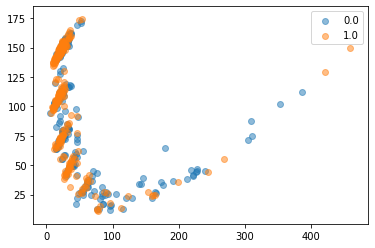

In [9]:
# ================= 2 Clusters based on original labels ================
org_label = y_train

for i in np.unique(org_label):
    plt.scatter(df_train[org_label == i, 0], df_train[org_label == i, 1], label = i, alpha=0.5)

plt.legend()
plt.show

print('train score', accuracy_score(km2_label, org_label))

km2_label_test = kmeans.predict(x_test)
org_label_test = y_test
print('test score', accuracy_score(km2_label_test, org_label_test))

km2_label_all = kmeans.predict(student_features)
org_label_all = student_performance.to_numpy()
print('score for all data', accuracy_score(km2_label_all, org_label_all))

In [10]:
# Plotting
def scatter_plot(labels, df):
    for i in np.unique(labels):
        plt.scatter(df[labels == i, 0], df[labels == i, 1], label = i)
    plt.legend()
    plt.show

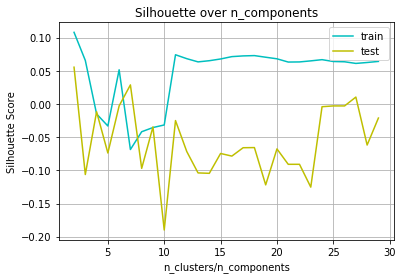

In [12]:
# ====================== GMM/EM with different numbers of clusters (Sil) ===========================

from sklearn.metrics import silhouette_score
sil_train = []
sil_test = []
n_clusters = []
kmax = 30

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax):
    n_clusters.append(k)
    em = mixture.GaussianMixture(n_components = k, random_state=2).fit(x_train)
    train_labels = em.predict(x_train)
    sil_train.append(silhouette_score(x_train, train_labels, metric = 'euclidean'))
    
    test_labels = em.predict(x_test)
    sil_test.append(silhouette_score(x_test, test_labels, metric = 'euclidean'))
    
# Plot
line_plot(title="Silhouette over n_components", x_label='n_clusters/n_components', y_label='Silhouette Score', \
          X=n_clusters, Y=[sil_train, sil_test], \
          lines=['train','test'], colors = ['c','y'])

Silhouette score
This score, as clearly stated by the SKLearn developers, consider two measures:
The mean distance between a sample and all other points in the same cluster.
The mean distance between a sample and all other points in the next nearest cluster.
i.e. it checks how much the clusters are compact and well separated. The more the score is near to one, the better the clustering is.

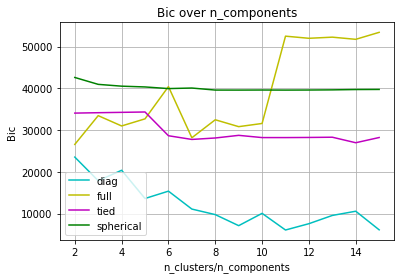

In [14]:
# ================= GMM/EM with different Covriance Type ======================

bics = []
covr_list = ['diag', 'full','tied', 'spherical']
n_clusters = [k for k in range(2,16)]

for covr_type in covr_list:
    bic = []
    for k in range(2,16):
        em = mixture.GaussianMixture(n_components=k, random_state=2, covariance_type=covr_type)
        em.fit(x_train)
        em_label = em.predict(x_train)
        bic.append(em.bic(x_train))
    bics.append(bic)

# Plot
line_plot(title="Bic over n_components", x_label='n_clusters/n_components', y_label='Bic', \
          X=n_clusters, Y=bics, \
          lines=covr_list, colors = ['c','y','m','g'])

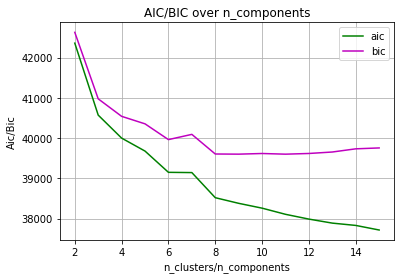

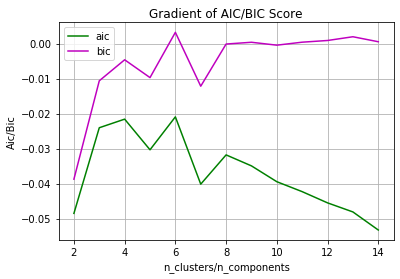

In [51]:
# ================= GMM/EM with different components ======================

# https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

def em_bic (x_train=x_train):
    aics = []
    bics = []

    for k in range(2,16):
        em = mixture.GaussianMixture(n_components=k, random_state=2, covariance_type='spherical')
        em.fit(x_train)
        em_label = em.predict(x_train)
        aics.append(em.aic(x_train))
        bics.append(em.bic(x_train))

    # Plot
    line_plot(title="AIC/BIC over n_components", x_label='n_clusters/n_components', y_label='Aic/Bic', \
              X=n_clusters, Y=[aics, bics], \
              lines=['aic', 'bic'], colors = ['g','m'])

    # Bic Gradient
    bic_gradient = []
    aic_gradient = []
    for i in range(len(bics)-1):
        bic_gradient.append((bics[i+1]-bics[i])/bics[i])
        aic_gradient.append((aics[i+1]-bics[i])/aics[i])
    # Plot
    line_plot(title="Gradient of AIC/BIC Score", x_label='n_clusters/n_components', y_label='Aic/Bic', \
              X=n_clusters[:-1], Y=[aic_gradient, bic_gradient], \
              lines=['aic', 'bic'], colors = ['g','m'])
    
em_bic()

In [16]:
# ================= GMM/EM with different Covriance Type ======================

for covr_type in ['diag', 'full','tied', 'spherical']:
    em = mixture.GaussianMixture(n_components=2, random_state=2, covariance_type=covr_type)
    
    em.fit(x_train)
    
    em_label_train = em.predict(x_train)
    train_score = accuracy_score(em_label_train, y_train)
    
    em_label_test = em.predict(x_test)
    test_score = accuracy_score(em_label_test, y_test)
    
    em.fit(student_features)
    em_label = em.predict(student_features)
    org_label = student_performance.to_numpy()
    score_all = accuracy_score(em_label, org_label)
    
    print("Train Score - (", covr_type ,"):", train_score)
    print("Test Score - (", covr_type ,"):", test_score)
    print("Overall Score - (", covr_type ,"):", score_all)


Train Score - ( diag ): 0.7013487475915221
Test Score - ( diag ): 0.6692307692307692
Overall Score - ( diag ): 0.539291217257319
Train Score - ( full ): 0.7013487475915221
Test Score - ( full ): 0.6692307692307692
Overall Score - ( full ): 0.539291217257319
Train Score - ( tied ): 0.5684007707129094
Test Score - ( tied ): 0.5615384615384615
Overall Score - ( tied ): 0.4345146379044684
Train Score - ( spherical ): 0.5626204238921002
Test Score - ( spherical ): 0.5538461538461539
Overall Score - ( spherical ): 0.4391371340523883


<function matplotlib.pyplot.show(*args, **kw)>

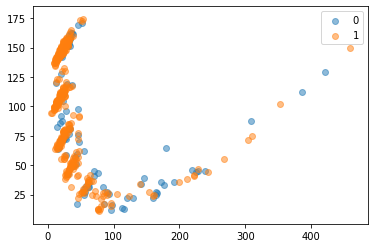

In [17]:
em2 = mixture.GaussianMixture(n_components=2, random_state=2, covariance_type='full')
em2.fit(x_train)
em2_label = em2.predict(x_train)
df_train = KMeans(n_clusters=2, random_state=2).fit_transform(x_train)**2
probs = em2.predict_proba(x_train)

for i in np.unique(em2_label):
    plt.scatter(df_train[em2_label == i, 0], df_train[em2_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show

In [18]:
# Dict to hold new features generated by clustering and dimensionality reduction
new_ft_train = {}
new_ft_test = {}

Features of  1  components:  ['absences']
Features of  2  components:  ['absences', 'age']
Features of  3  components:  ['absences', 'age', 'Walc']
Features of  4  components:  ['absences', 'age', 'Walc', 'reason']
Features of  5  components:  ['absences', 'age', 'Walc', 'reason', 'age']
Features of  6  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason']
Features of  7  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc']
Features of  8  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu']
Features of  9  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu', 'studytime']
Features of  10  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu', 'studytime', 'freetime']
Features of  11  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu', 'studytime', 'freetime', 'Fjob']
Features of  12  components:  ['absences', 'age', 'Walc', 'rea

C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Features of  24  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu', 'studytime', 'freetime', 'Fjob', 'studytime', 'traveltime', 'Medu', 'Dalc', 'failures', 'school', 'famsup', 'failures', 'famsize', 'famsup', 'romantic', 'nursery', 'internet']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Features of  25  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu', 'studytime', 'freetime', 'Fjob', 'studytime', 'traveltime', 'Medu', 'Dalc', 'failures', 'school', 'famsup', 'failures', 'famsize', 'famsup', 'romantic', 'nursery', 'internet', 'address']
Features of  26  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu', 'studytime', 'freetime', 'Fjob', 'studytime', 'traveltime', 'Medu', 'Dalc', 'failures', 'school', 'famsup', 'failures', 'famsize', 'famsup', 'romantic', 'nursery', 'internet', 'address', 'famsize']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Features of  27  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu', 'studytime', 'freetime', 'Fjob', 'studytime', 'traveltime', 'Medu', 'Dalc', 'failures', 'school', 'famsup', 'failures', 'famsize', 'famsup', 'romantic', 'nursery', 'internet', 'address', 'famsize', 'schoolsup']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Features of  28  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu', 'studytime', 'freetime', 'Fjob', 'studytime', 'traveltime', 'Medu', 'Dalc', 'failures', 'school', 'famsup', 'failures', 'famsize', 'famsup', 'romantic', 'nursery', 'internet', 'address', 'famsize', 'schoolsup', 'schoolsup']
Features of  29  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu', 'studytime', 'freetime', 'Fjob', 'studytime', 'traveltime', 'Medu', 'Dalc', 'failures', 'school', 'famsup', 'failures', 'famsize', 'famsup', 'romantic', 'nursery', 'internet', 'address', 'famsize', 'schoolsup', 'schoolsup', 'schoolsup']
Features of  30  components:  ['absences', 'age', 'Walc', 'reason', 'age', 'reason', 'Walc', 'Fedu', 'studytime', 'freetime', 'Fjob', 'studytime', 'traveltime', 'Medu', 'Dalc', 'failures', 'school', 'famsup', 'failures', 'famsize', 'famsup', 'romantic', 'nursery', 'internet', 'address', 'famsize', 'schoolsup', 'schoolsup', 'schoolsup',

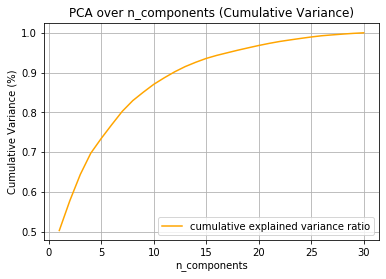

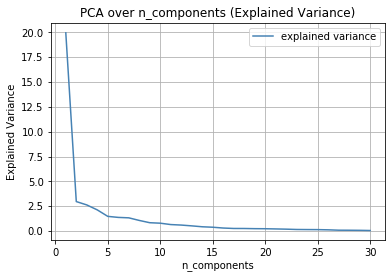

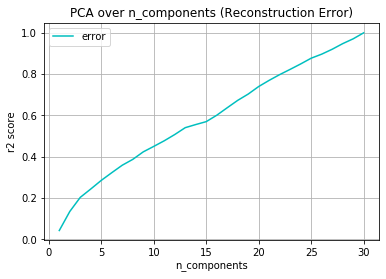

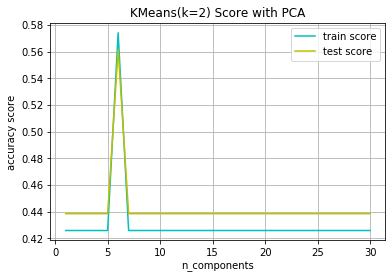

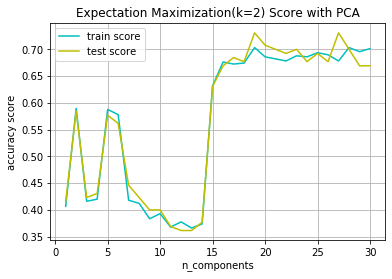

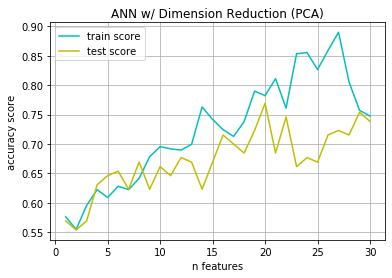

ANN w/ PCA - Train Score:  [0.5761078998073218, 0.5549132947976878, 0.5953757225433526, 0.6223506743737958, 0.6088631984585742, 0.628131021194605, 0.6223506743737958, 0.6416184971098265, 0.6782273603082851, 0.6955684007707129, 0.6917148362235067, 0.6897880539499036, 0.6994219653179191, 0.7630057803468208, 0.7418111753371869, 0.7244701348747592, 0.7129094412331407, 0.7379576107899807, 0.789980732177264, 0.7822736030828517, 0.8111753371868978, 0.7610789980732178, 0.8535645472061657, 0.8554913294797688, 0.8265895953757225, 0.859344894026975, 0.8901734104046243, 0.8053949903660886, 0.7572254335260116, 0.7475915221579962]
ANN w/ PCA - Test Score:  [0.5761078998073218, 0.5549132947976878, 0.5953757225433526, 0.6223506743737958, 0.6088631984585742, 0.628131021194605, 0.6223506743737958, 0.6416184971098265, 0.6782273603082851, 0.6955684007707129, 0.6917148362235067, 0.6897880539499036, 0.6994219653179191, 0.7630057803468208, 0.7418111753371869, 0.7244701348747592, 0.7129094412331407, 0.7379576

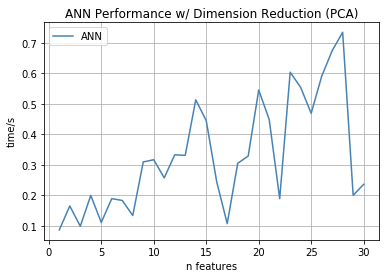

In [20]:
# ========================== PCA over different n_components ====================================
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

nmax = len(x_train.to_numpy()[0])
km_pca_train_score = []
km_pca_test_score = []
em_pca_train_score = []
em_pca_test_score = []
pca_ann_train_score = []
pca_ann_test_score = []
ann_time = []
    
nrmse = []
r2 = []

for i in range (1, nmax+1):
    pca = decomposition.PCA(n_components=i, random_state=2)
    x_train_compressed = pca.fit_transform(x_train)
    x_test_compressed = pca.transform(x_test)
    x_train_projected = pca.inverse_transform(x_train_compressed)
    
    # -------------- Reconstruction Error -------------------
    # In PCA Reconstruction error or loss is sum of eigen values of the ignored subspace.
    # https://stats.stackexchange.com/questions/194278/meaning-of-reconstruction-error-in-pca-and-lda
    r2.append(r2_score(x_train, x_train_projected))
    rmse = np.sqrt(mean_squared_error(x_train, x_train_projected))
    nrmse.append(rmse/np.sqrt(np.mean(x_train**2)))
    
    # --------------- K Means with Dimensionality Reduction ------------------
    #print('n_components, n=', i)
    #kmeans_inertia(x_train_compressed, x_test_compressed)
    kmeans = KMeans(n_clusters=2, random_state=2)
    df = kmeans.fit_transform(x_train_compressed)
    kmeans.fit(x_train_compressed)
    km_label_train = kmeans.labels_
    km_pca_train_score.append(accuracy_score(km_label_train, y_train))
    
    km_label_test = kmeans.predict(x_test_compressed)
    km_pca_test_score.append(accuracy_score(km_label_test, y_test))
    
    
    # --------------- Expectation Maximization with Dimensionality Reduction ------------------
    em = mixture.GaussianMixture(n_components=2, random_state=2, covariance_type='full')
    em.fit(x_train_compressed)
    
    em_label_train = em.predict(x_train_compressed)
    em_pca_train_score.append(accuracy_score(em_label_train, y_train))
    
    em_label_test = em.predict(x_test_compressed)
    em_pca_test_score.append(accuracy_score(em_label_test, y_test))
    
    
    # --------------- ANN with Dimensionality Reduction ------------------
    
    # get independent features
    max_idx = np.argmax(pca.components_, axis=1)
    pca_ft = []
    for idx in max_idx:
        pca_ft.append(x_train.columns.values.tolist()[idx])
    print('Features of ', i, ' components: ', pca_ft)
    
    x_train_pca_filtered = x_train.iloc[:,max_idx]
    x_test_pca_filtered = x_test.iloc[:,max_idx]
    
    t_start = timeit.default_timer()
    model = MLPClassifier(learning_rate_init = 0.01, random_state = 2)
    scores = ann_score(model, x_train_pca_filtered, x_test_pca_filtered)
    pca_ann_train_score.append(scores[0])
    pca_ann_test_score.append(scores[1])
    t_end = timeit.default_timer()
    ann_time.append(t_end - t_start)
    
    
# Plot
line_plot(title="PCA over n_components (Cumulative Variance)", x_label='n_components', y_label='Cumulative Variance (%)', \
          X=[i for i in range(1, nmax+1)], Y=[np.cumsum(pca.explained_variance_ratio_)], \
          lines=['cumulative explained variance ratio'], colors = ['orange'])

line_plot(title="PCA over n_components (Explained Variance)", x_label='n_components', y_label='Explained Variance', \
          X=[i for i in range(1, nmax+1)], Y=[pca.explained_variance_], \
          lines=['explained variance'], colors = ['steelblue'])

line_plot(title="PCA over n_components (Reconstruction Error)", x_label='n_components', y_label='r2 score', \
          X=[i for i in range(1, nmax+1)], Y=[r2], \
          lines=['error'], colors = ['c'])


line_plot(title="KMeans(k=2) Score with PCA", x_label='n_components', y_label='accuracy score', \
          X=[i for i in range(1, nmax+1)], Y=[km_pca_train_score, km_pca_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])

line_plot(title="Expectation Maximization(k=2) Score with PCA", x_label='n_components', y_label='accuracy score', \
          X=[i for i in range(1, nmax+1)], Y=[em_pca_train_score, em_pca_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])

line_plot(title="ANN w/ Dimension Reduction (PCA)", x_label='n features', y_label='accuracy score', \
          X=[i for i in range(1, len(x_train.to_numpy()[0])+1)], Y=[pca_ann_train_score, pca_ann_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])
print("ANN w/ PCA - Train Score: ", pca_ann_train_score)
print("ANN w/ PCA - Test Score: ", pca_ann_train_score)

line_plot(title="ANN Performance w/ Dimension Reduction (PCA)", x_label='n features', y_label='time/s', \
          X=[i for i in range(1, len(x_train.to_numpy()[0])+1)], Y=[ann_time], \
          lines=['ANN'], colors = ['steelblue'])
                      

In [47]:
pca = decomposition.PCA(n_components=30, random_state=2)
pca.fit_transform(x_train)
print(pca.explained_variance_ratio_)

[0.50262005 0.0747202  0.06621363 0.05362246 0.03722034 0.03458998
 0.03350507 0.02690783 0.02111665 0.01991325 0.01642722 0.01514888
 0.01312476 0.01083185 0.00967443 0.00762289 0.00653143 0.00647177
 0.00603308 0.00585504 0.00534269 0.00476588 0.00396553 0.00375248
 0.00360723 0.00309133 0.00213976 0.00202863 0.00180462 0.00135103]


In [21]:
print('km_pca_train_score: ',km_pca_train_score)
print('km_pca_test_score: ',km_pca_test_score)
print('em_pca_train_score: ',em_pca_train_score)
print('em_pca_test_score: ',em_pca_test_score)

km_pca_train_score:  [0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.5741811175337187, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813]
km_pca_test_score:  [0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.5615384615384615, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0.43846153846153846, 0

<function matplotlib.pyplot.show(*args, **kw)>

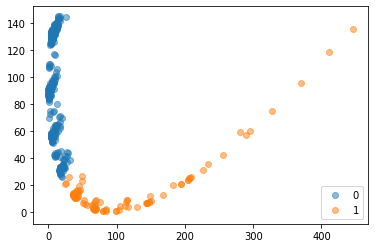

In [22]:
# ====================== K Means clusters with PCA 2 components ===================== 
x_train_compressed = decomposition.PCA(n_components=2, random_state=2).fit_transform(x_train)

kmeans = KMeans(n_clusters=2, random_state=2)
kmeans.fit(x_train_compressed)
df_train = kmeans.transform(x_train_compressed)**2
km2_label = kmeans.labels_

for i in np.unique(km2_label):
    plt.scatter(df_train[km2_label == i, 0], df_train[km2_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show

C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  f"KMeans is known to have a memory leak on Windows "


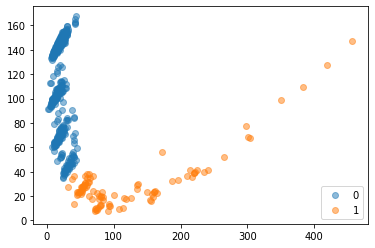

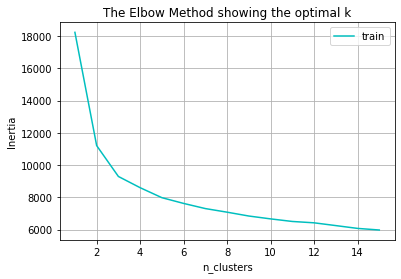

[18230.459097558796,
 11204.06008747464,
 9289.595923832423,
 8593.691610927208,
 7974.366303661797,
 7617.844133172981,
 7298.316315578618,
 7074.521874453694,
 6836.262671474045,
 6658.892627994154,
 6498.945296231876,
 6414.752969978813,
 6242.78144261305,
 6068.7496269768935,
 5968.738954739113]

In [54]:
# ====================== K Means clusters with PCA 11 components ===================== 
pca = decomposition.PCA(n_components=11, random_state=2)
x_train_compressed = pca.fit_transform(x_train)
x_test_compressed = pca.transform(x_test)

kmeans = KMeans(n_clusters=2, random_state=2)
kmeans.fit(x_train_compressed)
df_train = kmeans.transform(x_train_compressed)**2
km2_train_label = kmeans.labels_
km2_test_label = kmeans.predict(x_test_compressed)

for i in np.unique(km2_train_label):
    plt.scatter(df_train[km2_train_label == i, 0], df_train[km2_train_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show

# plot inertia
kmeans_inertia(x_train_compressed, x_test_compressed)

In [55]:
# ==================== Optimal k in K-Means with 11 component PCA =====================
kmeans = KMeans(n_clusters=3, random_state=2)
kmeans.fit(x_train_compressed)
df_train = kmeans.transform(x_train_compressed)**2
km2_train_label = kmeans.labels_
km2_test_label = kmeans.predict(x_test_compressed)

# add to new features dataframe
new_ft_train['km_pca'] = km2_train_label
new_ft_test['km_pca'] = km2_test_label

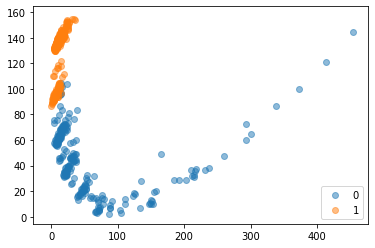

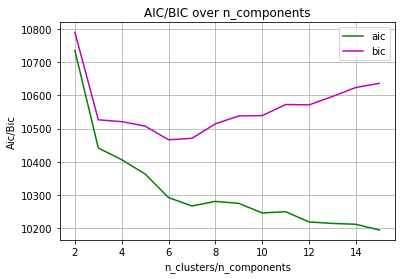

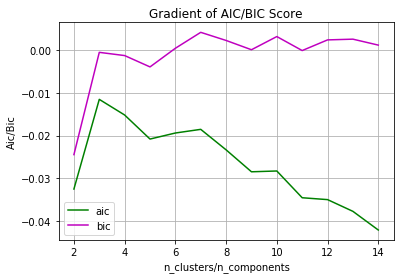

In [52]:
# ====================== EM clusters with PCA 11 components ===================== 
pca = decomposition.PCA(n_components=11, random_state=2)
x_train_compressed = pca.fit_transform(x_train)
x_test_compressed = pca.transform(x_test)

em = mixture.GaussianMixture(n_components=2, random_state=2, covariance_type='full')
em.fit(x_train_compressed)
em_train_label = em.predict(x_train_compressed)
df_train = KMeans(n_clusters=2, random_state=2).fit_transform(x_train_compressed)**2
probs = em.predict_proba(x_train_compressed)
em_test_label = em.predict(x_test_compressed)

for i in np.unique(em2_label):
    plt.scatter(df_train[em_train_label == i, 0], df_train[em_train_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show

# EM bics with different compoents given PCA 5 components
em_bic (x_train=x_train_compressed)

In [53]:
# add clusters by 6 component em to new features dataframe
em = mixture.GaussianMixture(n_components=6, random_state=2, covariance_type='full')
em.fit(x_train_compressed)
em_train_label = em.predict(x_train_compressed)
df_train = KMeans(n_clusters=2, random_state=2).fit_transform(x_train_compressed)**2
probs = em.predict_proba(x_train_compressed)
em_test_label = em.predict(x_test_compressed)

new_ft_train['em_pca'] = em_train_label
new_ft_test['em_pca'] = em_test_label

Features of  1  components:  ['absences']
Features of  2  components:  ['Medu', 'absences']
Features of  3  components:  ['Walc', 'absences', 'Medu']
Features of  4  components:  ['Walc', 'Walc', 'reason', 'Medu']
Features of  5  components:  ['age', 'health', 'traveltime', 'Walc', 'absences']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  6  components:  ['reason', 'health', 'age', 'health', 'Walc', 'traveltime']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  7  components:  ['age', 'age', 'goout', 'Mjob', 'health', 'goout', 'Walc']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  8  components:  ['goout', 'reason', 'Fedu', 'famrel', 'Walc', 'freetime', 'age', 'health']
Features of  9  components:  ['age', 'absences', 'studytime', 'famrel', 'Fedu', 'Fedu', 'goout', 'health', 'Mjob']
Features of  10  components:  ['age', 'goout', 'goout', 'Walc', 'Fjob', 'absences', 'Fjob', 'goout', 'Fedu', 'freetime']
Features of  11  components:  ['goout', 'absences', 'studytime', 'goout', 'Medu', 'freetime', 'famrel', 'freetime', 'Mjob', 'goout', 'health']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Features of  12  components:  ['Mjob', 'age', 'Fedu', 'age', 'Fjob', 'goout', 'goout', 'Medu', 'Dalc', 'studytime', 'Dalc', 'Fjob']
Features of  13  components:  ['age', 'goout', 'studytime', 'Walc', 'traveltime', 'traveltime', 'studytime', 'famrel', 'Fjob', 'Fjob', 'Dalc', 'Medu', 'Walc']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  14  components:  ['age', 'Medu', 'age', 'traveltime', 'traveltime', 'Fjob', 'famrel', 'studytime', 'Mjob', 'health', 'Walc', 'Dalc', 'absences', 'Dalc']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  15  components:  ['studytime', 'Mjob', 'studytime', 'Walc', 'age', 'studytime', 'goout', 'absences', 'studytime', 'traveltime', 'Fedu', 'Fjob', 'Walc', 'reason', 'traveltime']
Features of  16  components:  ['studytime', 'freetime', 'traveltime', 'Medu', 'Medu', 'Dalc', 'Medu', 'health', 'Dalc', 'studytime', 'Medu', 'Mjob', 'studytime', 'Walc', 'freetime', 'Walc']
Features of  17  components:  ['traveltime', 'studytime', 'studytime', 'Dalc', 'Dalc', 'sex', 'Medu', 'absences', 'freetime', 'failures', 'studytime', 'studytime', 'age', 'Medu', 'health', 'goout', 'Fjob']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  18  components:  ['Fjob', 'famsup', 'goout', 'studytime', 'Medu', 'Medu', 'health', 'Walc', 'absences', 'age', 'traveltime', 'famrel', 'Walc', 'school', 'freetime', 'reason', 'failures', 'guardian']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  19  components:  ['reason', 'Walc', 'freetime', 'Walc', 'studytime', 'Walc', 'traveltime', 'school', 'romantic', 'goout', 'failures', 'health', 'studytime', 'Mjob', 'romantic', 'studytime', 'Dalc', 'Fedu', 'famsup']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  20  components:  ['age', 'studytime', 'Dalc', 'Fjob', 'Medu', 'failures', 'health', 'goout', 'activities', 'activities', 'guardian', 'school', 'studytime', 'traveltime', 'famsize', 'studytime', 'freetime', 'Walc', 'famsup', 'age']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  21  components:  ['guardian', 'Fjob', 'traveltime', 'Mjob', 'sex', 'Pstatus', 'famrel', 'traveltime', 'guardian', 'guardian', 'Fedu', 'Walc', 'Fjob', 'famsup', 'studytime', 'famrel', 'activities', 'goout', 'higher', 'activities', 'Dalc']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  22  components:  ['traveltime', 'sex', 'famsize', 'Fjob', 'freetime', 'Walc', 'age', 'famsup', 'Medu', 'failures', 'studytime', 'famsize', 'famrel', 'guardian', 'Dalc', 'famsup', 'guardian', 'address', 'reason', 'health', 'activities', 'Medu']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  23  components:  ['internet', 'school', 'Fedu', 'Medu', 'school', 'guardian', 'failures', 'health', 'address', 'activities', 'traveltime', 'Medu', 'studytime', 'romantic', 'famsize', 'Fedu', 'sex', 'freetime', 'Dalc', 'Fjob', 'Walc', 'Medu', 'school']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  24  components:  ['address', 'school', 'schoolsup', 'Fjob', 'famsup', 'goout', 'activities', 'nursery', 'guardian', 'guardian', 'Walc', 'sex', 'Medu', 'Medu', 'nursery', 'nursery', 'schoolsup', 'school', 'guardian', 'nursery', 'famrel', 'Mjob', 'Walc', 'Pstatus']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  25  components:  ['guardian', 'address', 'activities', 'age', 'Fjob', 'schoolsup', 'studytime', 'internet', 'activities', 'nursery', 'goout', 'Medu', 'Pstatus', 'guardian', 'Walc', 'health', 'traveltime', 'Medu', 'Dalc', 'freetime', 'freetime', 'failures', 'guardian', 'famrel', 'schoolsup']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  26  components:  ['Medu', 'reason', 'nursery', 'address', 'famrel', 'address', 'school', 'nursery', 'Dalc', 'activities', 'internet', 'freetime', 'guardian', 'schoolsup', 'school', 'Walc', 'school', 'internet', 'romantic', 'internet', 'address', 'nursery', 'Medu', 'address', 'guardian', 'address']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  27  components:  ['guardian', 'famsup', 'address', 'Fjob', 'guardian', 'famsize', 'internet', 'Fedu', 'Pstatus', 'schoolsup', 'reason', 'nursery', 'higher', 'schoolsup', 'nursery', 'romantic', 'schoolsup', 'nursery', 'address', 'internet', 'nursery', 'sex', 'Walc', 'nursery', 'traveltime', 'Mjob', 'Dalc']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Features of  28  components:  ['nursery', 'health', 'Fedu', 'failures', 'address', 'Fjob', 'activities', 'Dalc', 'address', 'famrel', 'schoolsup', 'school', 'activities', 'failures', 'Pstatus', 'Medu', 'internet', 'guardian', 'school', 'internet', 'studytime', 'schoolsup', 'nursery', 'nursery', 'internet', 'sex', 'famsize', 'activities']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  29  components:  ['studytime', 'Pstatus', 'sex', 'school', 'address', 'reason', 'guardian', 'guardian', 'famrel', 'nursery', 'internet', 'school', 'nursery', 'nursery', 'address', 'school', 'Fedu', 'address', 'higher', 'Dalc', 'schoolsup', 'Mjob', 'sex', 'traveltime', 'health', 'higher', 'sex', 'age', 'guardian']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Features of  30  components:  ['sex', 'Fjob', 'guardian', 'schoolsup', 'Walc', 'goout', 'school', 'schoolsup', 'Pstatus', 'guardian', 'internet', 'schoolsup', 'internet', 'famsup', 'Dalc', 'freetime', 'address', 'guardian', 'internet', 'age', 'Dalc', 'guardian', 'nursery', 'Medu', 'goout', 'famsize', 'reason', 'school', 'Medu', 'activities']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


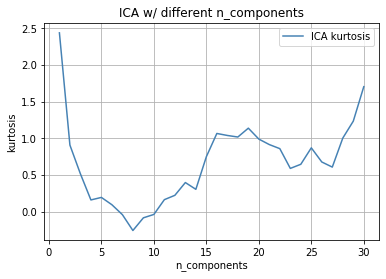

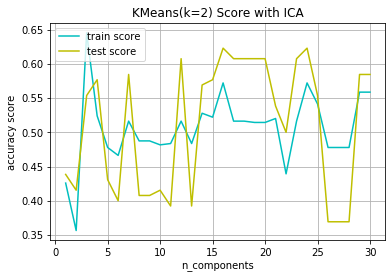

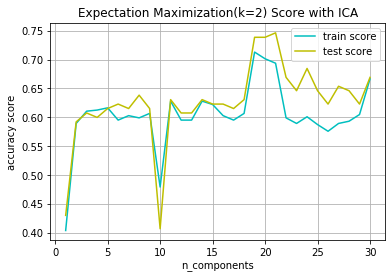

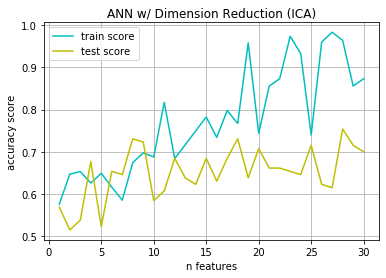

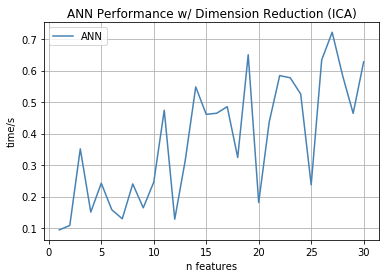

In [33]:
# ========================== ICA over different n_components ====================================

from scipy.stats import kurtosis

kurts = []
nmax = len(x_train.to_numpy()[0])

km_ica_train_score = []
km_ica_test_score = []
em_ica_train_score = []
em_ica_test_score = []
ica_ann_train_score = []
ica_ann_test_score = []
ann_time = []

for i in range (1, nmax+1):
    ica = decomposition.FastICA(n_components=i, random_state=2)
    x_train_transformed = ica.fit_transform(x_train)
    x_test_transformed = ica.transform(x_test)
    
    # get kurtosis
    kurts.append(kurtosis(x_train_transformed).mean())
    
    # --------------- K Means with Dimensionality Reduction ------------------
    kmeans = KMeans(n_clusters=2, random_state=2)
    df = kmeans.fit_transform(x_train_transformed)
    kmeans.fit(x_train_transformed)
    km_label_train = kmeans.labels_
    km_ica_train_score.append(accuracy_score(km_label_train, y_train))
    
    km_label_test = kmeans.predict(x_test_transformed)
    km_ica_test_score.append(accuracy_score(km_label_test, y_test))
    
    
    # --------------- Expectation Maximization with Dimensionality Reduction ------------------
    em = mixture.GaussianMixture(n_components=2, random_state=2, covariance_type='full')
    em.fit(x_train_transformed)
    
    em_label_train = em.predict(x_train_transformed)
    em_ica_train_score.append(accuracy_score(em_label_train, y_train))
    
    em_label_test = em.predict(x_test_transformed)
    em_ica_test_score.append(accuracy_score(em_label_test, y_test))
    
    
    # --------------- ANN with Dimensionality Reduction ------------------
    
    # get independent features
    max_idx = np.argmax(ica.components_, axis=1)
    ica_ft = []
    for idx in max_idx:
        ica_ft.append(x_train.columns.values.tolist()[idx])
    print('Features of ', i, ' components: ', ica_ft)
    
    x_train_ica_filtered = x_train.iloc[:,max_idx]
    x_test_ica_filtered = x_test.iloc[:,max_idx]
    
    t_start = timeit.default_timer()
    model = MLPClassifier(learning_rate_init = 0.01, random_state = 2)
    scores = ann_score(model, x_train_ica_filtered, x_test_ica_filtered)
    ica_ann_train_score.append(scores[0])
    ica_ann_test_score.append(scores[1])
    t_end = timeit.default_timer()
    ann_time.append(t_end - t_start)

line_plot(title="ICA w/ different n_components", x_label='n_components', y_label='kurtosis', \
          X=[i for i in range(1, nmax+1)], Y=[kurts], \
          lines=['ICA kurtosis'], colors = ['steelblue'])

line_plot(title="KMeans(k=2) Score with ICA", x_label='n_components', y_label='accuracy score', \
          X=[i for i in range(1, nmax+1)], Y=[km_ica_train_score, km_ica_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])

line_plot(title="Expectation Maximization(k=2) Score with ICA", x_label='n_components', y_label='accuracy score', \
          X=[i for i in range(1, nmax+1)], Y=[em_ica_train_score, em_ica_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])

line_plot(title="ANN w/ Dimension Reduction (ICA)", x_label='n features', y_label='accuracy score', \
          X=[i for i in range(1, len(x_train.to_numpy()[0])+1)], Y=[ica_ann_train_score, ica_ann_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])

line_plot(title="ANN Performance w/ Dimension Reduction (ICA)", x_label='n features', y_label='time/s', \
          X=[i for i in range(1, len(x_train.to_numpy()[0])+1)], Y=[ann_time], \
          lines=['ANN'], colors = ['steelblue'])

C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


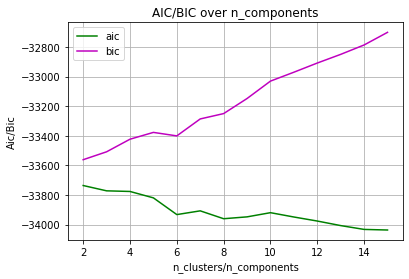

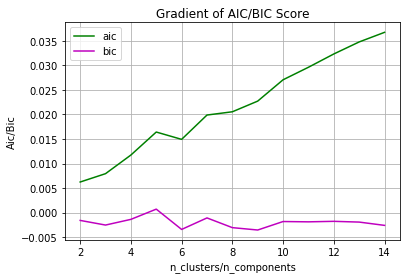

<function matplotlib.pyplot.show(*args, **kw)>

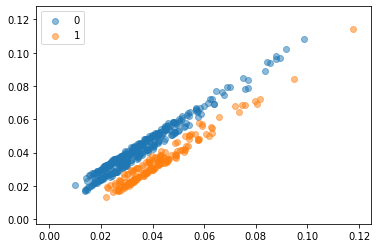

In [56]:
# ====================== K Means clusters with ICA 19 components ===================== 
ica = decomposition.FastICA(n_components=19, random_state=2)
x_train_compressed = ica.fit_transform(x_train)
x_test_compressed = ica.transform(x_test)

kmeans = KMeans(n_clusters=2, random_state=2)
kmeans.fit(x_train_compressed)
df_train = kmeans.transform(x_train_compressed)**2
km2_train_label = kmeans.labels_
km2_test_label = kmeans.predict(x_test_compressed)

em_bic(x_train_compressed)

for i in np.unique(km2_train_label):
    plt.scatter(df_train[km2_train_label == i, 0], df_train[km2_train_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


<function matplotlib.pyplot.show(*args, **kw)>

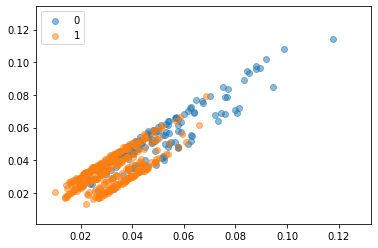

In [61]:
# ====================== EM clusters with ICA 19 components ===================== 
ica = decomposition.FastICA(n_components=19, random_state=2)
x_train_compressed = ica.fit_transform(x_train)
x_test_compressed = ica.transform(x_test)

em = mixture.GaussianMixture(n_components=2, random_state=2, covariance_type='full')
em.fit(x_train_compressed)
em_train_label = em.predict(x_train_compressed)
df_train = KMeans(n_clusters=2, random_state=2).fit_transform(x_train_compressed)**2
probs = em.predict_proba(x_train_compressed)
em_test_label = em.predict(x_test_compressed)

for i in np.unique(em2_label):
    plt.scatter(df_train[em_train_label == i, 0], df_train[em_train_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show

In [63]:
# add clusters by 19 component em to new features dataframe
em = mixture.GaussianMixture(n_components=19, random_state=2, covariance_type='full')
em.fit(x_train_compressed)
em_train_label = em.predict(x_train_compressed)
df_train = KMeans(n_clusters=2, random_state=2).fit_transform(x_train_compressed)**2
probs = em.predict_proba(x_train_compressed)
em_test_label = em.predict(x_test_compressed)

new_ft_train['em_ica'] = em_train_label
new_ft_test['em_ica'] = em_test_label

C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\random_projection.py:377: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (1 < 30).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\random_projection.py:377: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 30).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\random_projection.py:377: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (3 < 30).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)
C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\random_projection.py:377: DataDimensionalityWarning: The number of c

C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\random_projection.py:377: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (29 < 30).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


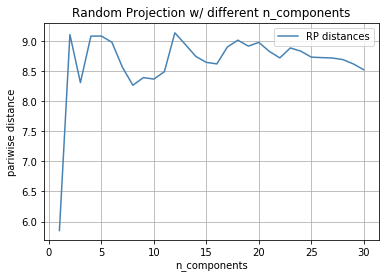

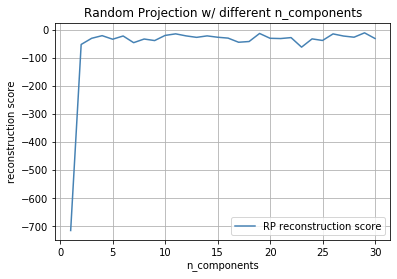

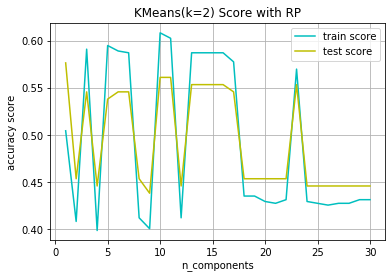

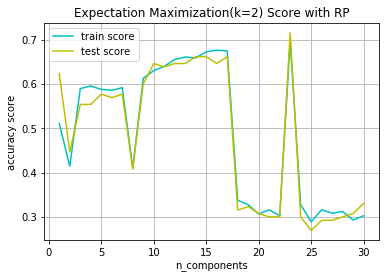

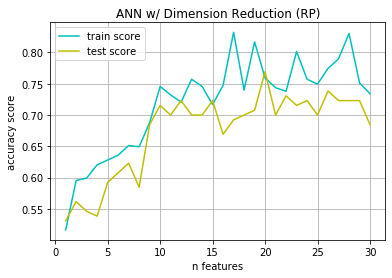

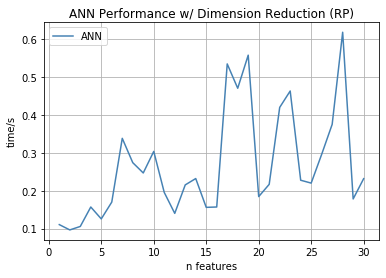

In [85]:
# ========================== Random Projection over different n_components ====================================

from sklearn.metrics import pairwise_distances

distances = []
r2 = []
nmax = len(x_train.to_numpy()[0])

km_rp_train_score = []
km_rp_test_score = []
em_rp_train_score = []
em_rp_test_score = []
rp_ann_train_score = []
rp_ann_test_score = []
ann_time = []

for i in range (1, nmax+1):
    rp = random_projection.GaussianRandomProjection(n_components=i, random_state=2)
    x_train_transformed = rp.fit_transform(x_train)
    
    distances.append(pairwise_distances(x_train_transformed).mean())
    rp_inverse = random_projection.GaussianRandomProjection(n_components=30, random_state=2)
    r2.append(r2_score(rp_inverse.fit_transform(x_train_transformed), x_train))

    x_test_transformed = rp.transform(x_test)

    # --------------- K Means with Dimensionality Reduction ------------------
    kmeans = KMeans(n_clusters=2, random_state=2)
    df = kmeans.fit_transform(x_train_transformed)
    kmeans.fit(x_train_transformed)
    km_label_train = kmeans.labels_
    km_rp_train_score.append(accuracy_score(km_label_train, y_train))
    
    km_label_test = kmeans.predict(x_test_transformed)
    km_rp_test_score.append(accuracy_score(km_label_test, y_test))
    
    
    # --------------- Expectation Maximization with Dimensionality Reduction ------------------
    em = mixture.GaussianMixture(n_components=2, random_state=2, covariance_type='full')
    em.fit(x_train_transformed)
    
    em_label_train = em.predict(x_train_transformed)
    em_rp_train_score.append(accuracy_score(em_label_train, y_train))
    
    em_label_test = em.predict(x_test_transformed)
    em_rp_test_score.append(accuracy_score(em_label_test, y_test))
    
    
    # --------------- ANN with Dimensionality Reduction ------------------

    t_start = timeit.default_timer()
    model = MLPClassifier(learning_rate_init = 0.01, random_state = 2)
    scores = ann_score(model, x_train_transformed, x_test_transformed)
    rp_ann_train_score.append(scores[0])
    rp_ann_test_score.append(scores[1])
    t_end = timeit.default_timer()
    ann_time.append(t_end - t_start)
    
# Plot
line_plot(title="Random Projection w/ different n_components", x_label='n_components', y_label='pariwise distance', \
          X=[i for i in range(1, nmax+1)], Y=[distances], \
          lines=['RP distances'], colors = ['steelblue'])

# Plot
line_plot(title="Random Projection w/ different n_components", x_label='n_components', y_label='reconstruction score', \
          X=[i for i in range(1, nmax+1)], Y=[r2], \
          lines=['RP reconstruction score'], colors = ['steelblue'])

line_plot(title="KMeans(k=2) Score with RP", x_label='n_components', y_label='accuracy score', \
          X=[i for i in range(1, nmax+1)], Y=[km_rp_train_score, km_rp_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])

line_plot(title="Expectation Maximization(k=2) Score with RP", x_label='n_components', y_label='accuracy score', \
          X=[i for i in range(1, nmax+1)], Y=[em_rp_train_score, em_rp_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])

line_plot(title="ANN w/ Dimension Reduction (RP)", x_label='n features', y_label='accuracy score', \
          X=[i for i in range(1, len(x_train.to_numpy()[0])+1)], Y=[rp_ann_train_score, rp_ann_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])

line_plot(title="ANN Performance w/ Dimension Reduction (RP)", x_label='n features', y_label='time/s', \
          X=[i for i in range(1, len(x_train.to_numpy()[0])+1)], Y=[ann_time], \
          lines=['ANN'], colors = ['steelblue'])


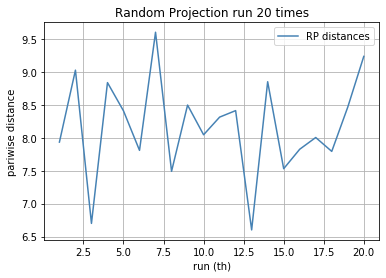

RP variance (20 times):  0.556802885872153


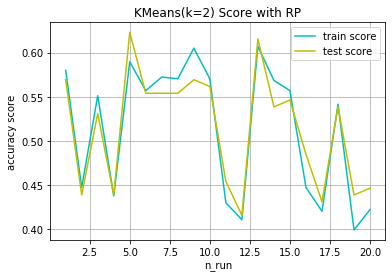

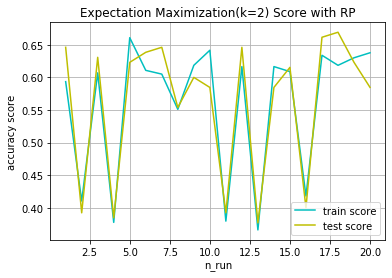

In [84]:
def score_cal(model, x_train, x_test, y_train=y_train, y_test=y_test):
    model.fit(x_train)
    label_train = model.predict(x_train)
    train_score = accuracy_score(label_train, y_train)
    
    label_test = model.predict(x_test)
    test_score = accuracy_score(label_test, y_test)
    
    return [train_score, test_score]

distance = []
km_tr_score = []
km_ts_score = []
em_tr_score = []
em_ts_score = []

for i in range (20):
    rp = random_projection.GaussianRandomProjection(n_components=10)
    x_train_transformed = rp.fit_transform(x_train)
    x_test_transformed = rp.transform(x_test)
    
    result = score_cal(KMeans(n_clusters=2, random_state=2), x_train_transformed, x_test_transformed)
    km_tr_score.append(result[0])
    km_ts_score.append(result[1])
    
    result2 = score_cal(mixture.GaussianMixture(n_components=2, random_state=2, covariance_type='full')\
                        , x_train_transformed, x_test_transformed)
    em_tr_score.append(result2[0])
    em_ts_score.append(result2[1])
    
    distance.append(pairwise_distances(x_train_transformed).mean())

line_plot(title="Random Projection run 20 times", x_label='run (th)', y_label='pariwise distance', \
          X=[i for i in range(1, 21)], Y=[distance], \
          lines=['RP distances'], colors = ['steelblue'])

print("RP variance (20 times): ", np.var(distance))

line_plot(title="KMeans(k=2) Score with RP", x_label='n_run', y_label='accuracy score', \
          X=[i for i in range(1, 21)], Y=[km_tr_score, km_ts_score], \
          lines=['train score', 'test score'], colors = ['c','y'])

line_plot(title="Expectation Maximization(k=2) Score with RP", x_label='n_run', y_label='accuracy score', \
          X=[i for i in range(1, 21)], Y=[em_tr_score, em_ts_score], \
          lines=['train score', 'test score'], colors = ['c','y'])

C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  f"KMeans is known to have a memory leak on Windows "


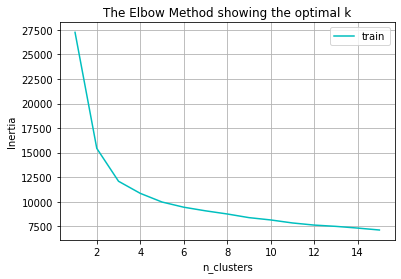

<function matplotlib.pyplot.show(*args, **kw)>

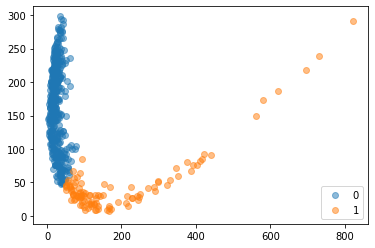

In [78]:
# ====================== K Means clusters with RP 12 components ===================== 
rp = random_projection.GaussianRandomProjection(n_components=12, random_state=2)
x_train_compressed = rp.fit_transform(x_train)
x_test_compressed = rp.transform(x_test)

kmeans = KMeans(n_clusters=2, random_state=2)
kmeans.fit(x_train_compressed)
df_train = kmeans.transform(x_train_compressed)**2
km2_train_label = kmeans.labels_
km2_test_label = kmeans.predict(x_test_compressed)

kmeans_inertia(x_train_compressed, x_test_compressed)

for i in np.unique(km2_train_label):
    plt.scatter(df_train[km2_train_label == i, 0], df_train[km2_train_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show


In [66]:
# ==================== Optimal k in K-Means with 11 component PCA =====================
kmeans = KMeans(n_clusters=3, random_state=2)
kmeans.fit(x_train_compressed)
df_train = kmeans.transform(x_train_compressed)**2
km2_train_label = kmeans.labels_
km2_test_label = kmeans.predict(x_test_compressed)

# add to new features dataframe
new_ft_train['km_rp'] = km2_train_label
new_ft_test['km_rp'] = km2_test_label

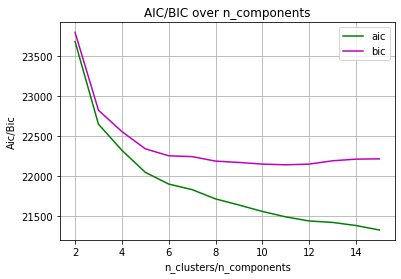

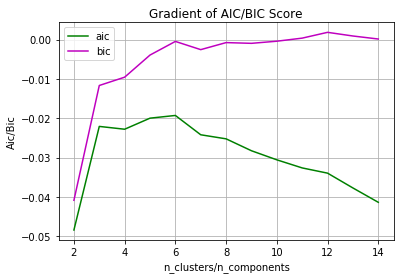

<function matplotlib.pyplot.show(*args, **kw)>

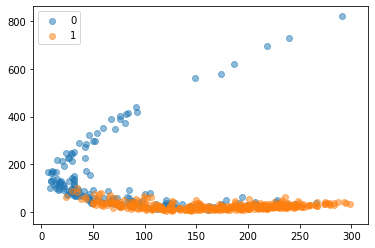

In [67]:
# ====================== EM clusters with RP 12 components ===================== 
rp = random_projection.GaussianRandomProjection(n_components=12, random_state=2)
x_train_compressed = rp.fit_transform(x_train)
x_test_compressed = rp.transform(x_test)

em = mixture.GaussianMixture(n_components=2, random_state=2, covariance_type='full')
em.fit(x_train_compressed)
em_train_label = em.predict(x_train_compressed)
df_train = KMeans(n_clusters=2, random_state=2).fit_transform(x_train_compressed)**2
probs = em.predict_proba(x_train_compressed)
em_test_label = em.predict(x_test_compressed)

em_bic(x_train_compressed)

for i in np.unique(em2_label):
    plt.scatter(df_train[em_train_label == i, 0], df_train[em_train_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show

In [68]:
# add clusters by 6 component em to new features dataframe
em = mixture.GaussianMixture(n_components=6, random_state=2, covariance_type='full')
em.fit(x_train_compressed)
em_train_label = em.predict(x_train_compressed)
df_train = KMeans(n_clusters=2, random_state=2).fit_transform(x_train_compressed)**2
probs = em.predict_proba(x_train_compressed)
em_test_label = em.predict(x_test_compressed)

new_ft_train['em_ica'] = em_train_label
new_ft_test['em_ica'] = em_test_label

In [69]:
# Method for KM and EM with Dimension Reduction Score 

def cluster_score(model, x_train, x_test, y_train=y_train, y_test=y_test):

    model.fit(x_train)
    train_label = model.predict(x_train)
    test_label = model.predict(x_test)

    train_score = accuracy_score(train_label, y_train)
    test_score = accuracy_score(test_label, y_test)

    return [train_score, test_score]

DT important features:  [0.07233439 0.         0.01881913 0.03393929 0.         0.00762003
 0.         0.06947332 0.         0.019968   0.         0.
 0.01830726 0.         0.3358324  0.02470791 0.0082753  0.
 0.         0.         0.36636381 0.         0.         0.
 0.         0.         0.         0.00135417 0.00830256 0.01470244]
(DT) Features of  1  components:  ['higher']
(DT) Features of  1  components:  ['higher', 'failures']
(DT) Features of  1  components:  ['higher', 'failures', 'school']
(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu']
(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address']
(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup']
(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob']
(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age']
(DT) Features 

C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'Mjob', 'Medu']
(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'Medu', 'Mjob', 'reason']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'Medu', 'Mjob', 'reason', 'famsize']
(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'Medu', 'Mjob', 'reason', 'famsize', 'guardian']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'reason', 'Mjob', 'Medu', 'famsize', 'guardian', 'Dalc']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'Dalc', 'Medu', 'guardian', 'Mjob', 'reason', 'famsize', 'paid']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'famsize', 'goout', 'reason', 'guardian', 'Dalc', 'paid', 'Medu', 'Mjob']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'famsize', 'studytime', 'reason', 'guardian', 'Dalc', 'paid', 'goout', 'Medu', 'Mjob']
(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'studytime', 'goout', 'famsize', 'Medu', 'Mjob', 'Dalc', 'guardian', 'reason', 'paid', 'freetime']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'paid', 'Mjob', 'goout', 'guardian', 'Medu', 'famsize', 'studytime', 'reason', 'freetime', 'Dalc', 'romantic']
(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'guardian', 'Dalc', 'Mjob', 'paid', 'goout', 'Medu', 'famsize', 'freetime', 'studytime', 'romantic', 'reason', 'sex']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'guardian', 'Dalc', 'paid', 'Mjob', 'goout', 'freetime', 'Medu', 'famsize', 'studytime', 'romantic', 'sex', 'reason', 'nursery']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'Dalc', 'goout', 'freetime', 'famrel', 'romantic', 'reason', 'guardian', 'nursery', 'activities', 'paid', 'Mjob', 'studytime', 'internet', 'Medu']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'Dalc', 'goout', 'freetime', 'famrel', 'romantic', 'internet', 'guardian', 'nursery', 'activities', 'paid', 'Medu', 'studytime', 'Mjob', 'reason', 'famsize']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(DT) Features of  1  components:  ['higher', 'failures', 'school', 'Fedu', 'address', 'schoolsup', 'Fjob', 'age', 'traveltime', 'absences', 'health', 'famsup', 'Pstatus', 'Walc', 'reason', 'Dalc', 'goout', 'freetime', 'famrel', 'romantic', 'internet', 'nursery', 'Mjob', 'activities', 'paid', 'studytime', 'Medu', 'guardian', 'famsize', 'sex']


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


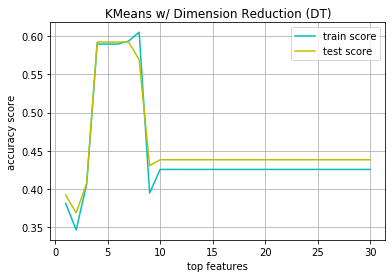

KMeans w/ DT - Train Score:  [0.3815028901734104, 0.3468208092485549, 0.40655105973025046, 0.5895953757225434, 0.5895953757225434, 0.5895953757225434, 0.5934489402697495, 0.605009633911368, 0.394990366088632, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813]
KMeans w/ DT - Test Score:  [0.3815028901734104, 0.3468208092485549, 0.40655105973025046, 0.5895953757225434, 0.5895953757225434, 0.5895953757225434, 0.5934489402697495, 0.605009633911368, 0.394990366088632, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4258188824662813, 0.4

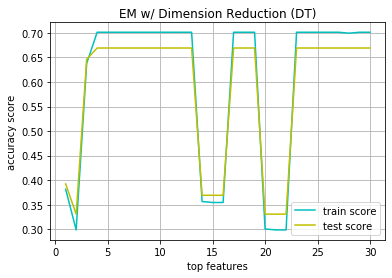

EM w/ DT - Train Score:  [0.3815028901734104, 0.29865125240847784, 0.6377649325626205, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.35645472061657035, 0.35452793834296725, 0.35452793834296725, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.30057803468208094, 0.29865125240847784, 0.29865125240847784, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.6994219653179191, 0.7013487475915221, 0.7013487475915221]
EM w/ DT - Test Score:  [0.3815028901734104, 0.29865125240847784, 0.6377649325626205, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.7013487475915221, 0.35645472061657035, 0.35452793834296725, 0.35452793834296725, 0.7013487475915221

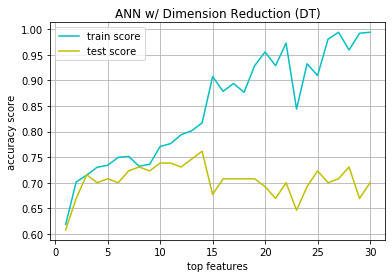

ANN w/ DT - Train Score:  [0.6184971098265896, 0.7013487475915221, 0.7148362235067437, 0.7302504816955684, 0.7341040462427746, 0.7495183044315993, 0.7514450867052023, 0.7321772639691715, 0.7360308285163777, 0.7707129094412332, 0.7764932562620424, 0.7938342967244701, 0.8015414258188824, 0.8169556840077071, 0.9075144508670521, 0.8786127167630058, 0.8940269749518305, 0.8766859344894027, 0.928709055876686, 0.9556840077071291, 0.928709055876686, 0.9730250481695568, 0.8439306358381503, 0.9325626204238922, 0.9094412331406551, 0.9807321772639692, 0.9942196531791907, 0.9595375722543352, 0.9922928709055877, 0.9942196531791907]
ANN w/ DT - Test Score:  [0.6184971098265896, 0.7013487475915221, 0.7148362235067437, 0.7302504816955684, 0.7341040462427746, 0.7495183044315993, 0.7514450867052023, 0.7321772639691715, 0.7360308285163777, 0.7707129094412332, 0.7764932562620424, 0.7938342967244701, 0.8015414258188824, 0.8169556840077071, 0.9075144508670521, 0.8786127167630058, 0.8940269749518305, 0.8766859

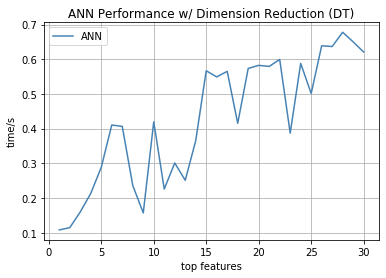

In [39]:
# ========================== Choice: DT for dimension reduction ====================================

dt = DecisionTreeClassifier(max_depth = 5, max_features = 'sqrt', random_state = 2, criterion = 'gini')
dt.fit(x_train, y_train)
imp_feature = dt.feature_importances_
print('DT important features: ', imp_feature)

dt_km_train_score = []
dt_km_test_score = []
dt_em_train_score = []
dt_em_test_score = []
dt_ann_train_score = []
dt_ann_test_score = []
ann_time = []

# Get top n features
for n in range (1, len(x_train.to_numpy()[0])+1):
    idx = np.argpartition(imp_feature, -n)[-n:]
    dt_ft_idx = idx[np.argsort((-imp_feature)[idx])]
    
    # get independent features
    dt_ft = []
    for idx in dt_ft_idx:
        dt_ft.append(x_train.columns.values.tolist()[idx])
    print('(DT) Features of ', i, ' components: ', dt_ft)

    x_train_dt_filtered = x_train.iloc[:,dt_ft_idx]
    x_test_dt_filtered = x_test.iloc[:,dt_ft_idx]
    
    # K Means
    model = KMeans(n_clusters=2, random_state=2)
    scores = cluster_score(model, x_train_dt_filtered, x_test_dt_filtered)
    dt_km_train_score.append(scores[0])
    dt_km_test_score.append(scores[1])
    
    # Expectation Maximization
    model = mixture.GaussianMixture(n_components=2, random_state=2, covariance_type='full')
    scores = cluster_score(model, x_train_dt_filtered, x_test_dt_filtered)
    dt_em_train_score.append(scores[0])
    dt_em_test_score.append(scores[1])
    
    # Neural Network
    t_start = timeit.default_timer()
    model = MLPClassifier(learning_rate_init = 0.01, random_state = 2)
    scores = ann_score(model, x_train_dt_filtered, x_test_dt_filtered)
    dt_ann_train_score.append(scores[0])
    dt_ann_test_score.append(scores[1])
    t_end = timeit.default_timer()
    ann_time.append(t_end - t_start)
    
line_plot(title="KMeans w/ Dimension Reduction (DT)", x_label='top features', y_label='accuracy score', \
          X=[i for i in range(1, len(x_train.to_numpy()[0])+1)], Y=[dt_km_train_score, dt_km_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])
print("KMeans w/ DT - Train Score: ", dt_km_train_score)
print("KMeans w/ DT - Test Score: ", dt_km_train_score)

line_plot(title="EM w/ Dimension Reduction (DT)", x_label='top features', y_label='accuracy score', \
          X=[i for i in range(1, len(x_train.to_numpy()[0])+1)], Y=[dt_em_train_score, dt_em_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])
print("EM w/ DT - Train Score: ", dt_em_train_score)
print("EM w/ DT - Test Score: ", dt_em_train_score)

line_plot(title="ANN w/ Dimension Reduction (DT)", x_label='top features', y_label='accuracy score', \
          X=[i for i in range(1, len(x_train.to_numpy()[0])+1)], Y=[dt_ann_train_score, dt_ann_test_score], \
          lines=['train score', 'test score'], colors = ['c','y'])
print("ANN w/ DT - Train Score: ", dt_ann_train_score)
print("ANN w/ DT - Test Score: ", dt_ann_train_score)

line_plot(title="ANN Performance w/ Dimension Reduction (DT)", x_label='top features', y_label='time/s', \
          X=[i for i in range(1, len(x_train.to_numpy()[0])+1)], Y=[ann_time], \
          lines=['ANN'], colors = ['steelblue'])


<function matplotlib.pyplot.show(*args, **kw)>

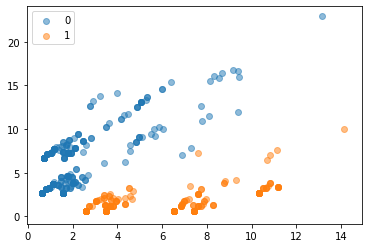

In [40]:
# ====================== K Means clusters with DT 7 features ===================== 
n=7
idx = np.argpartition(imp_feature, -n)[-n:]
dt_ft_idx = idx[np.argsort((-imp_feature)[idx])]

x_train_compressed = x_train.iloc[:,dt_ft_idx]
x_test_compressed = x_test.iloc[:,dt_ft_idx]

kmeans = KMeans(n_clusters=2, random_state=2)
kmeans.fit(x_train_compressed)
df_train = kmeans.transform(x_train_compressed)**2
km2_train_label = kmeans.labels_
km2_test_label = kmeans.predict(x_test_compressed)

# add to new features dataframe
new_ft_train['km_dt'] = km2_train_label
new_ft_test['km_dt'] = km2_test_label

for i in np.unique(km2_train_label):
    plt.scatter(df_train[km2_train_label == i, 0], df_train[km2_train_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

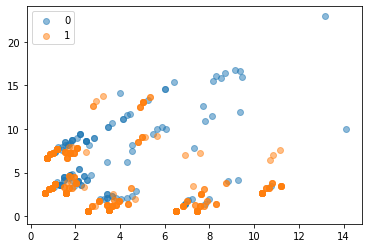

In [86]:
# ====================== EM clusters with DT 7 features ===================== 
n=7
idx = np.argpartition(imp_feature, -n)[-n:]
dt_ft_idx = idx[np.argsort((-imp_feature)[idx])]

x_train_compressed = x_train.iloc[:,dt_ft_idx]
x_test_compressed = x_test.iloc[:,dt_ft_idx]

em = mixture.GaussianMixture(n_components=2, random_state=2, covariance_type='full')
em.fit(x_train_compressed)
em_train_label = em.predict(x_train_compressed)
df_train = KMeans(n_clusters=2, random_state=2).fit_transform(x_train_compressed)**2
probs = em.predict_proba(x_train_compressed)
em_test_label = em.predict(x_test_compressed)

# add to new features dataframe
new_ft_train['em_ica'] = em_train_label
new_ft_test['em_ica'] = em_test_label

for i in np.unique(em2_label):
    plt.scatter(df_train[em_train_label == i, 0], df_train[em_train_label == i, 1], label = i, alpha=0.5)
plt.legend()
plt.show

In [87]:
# Put dict of new features after clustering to dataframe
df_new_ft_tr = pd.DataFrame(new_ft_train)
df_new_ft_ts = pd.DataFrame(new_ft_test)

In [92]:
# =================== ANN on New Features (Cluster Labels) ===================

t_start = timeit.default_timer()
model = MLPClassifier(learning_rate_init = 0.01, random_state = 2)
scores = ann_score(model, df_new_ft_tr, df_new_ft_ts)
new_ft_tr_score = scores[0]
new_ft_ts_score = scores[1]
t_end = timeit.default_timer()
new_ft_ann_time = (t_end - t_start)

print("ANN Train Score over New Features: ", new_ft_tr_score)
print("ANN Test Score over New Features: ", new_ft_ts_score)
print("ANN Run Time over New Features: ", new_ft_ann_time)

ANN Train Score over New Features:  0.7707129094412332
ANN Test Score over New Features:  0.7384615384615385
ANN Run Time over New Features:  0.38126130000455305


In [93]:
# =================== ANN on Original Data ===================

t_start = timeit.default_timer()
model = MLPClassifier(learning_rate_init = 0.01, random_state = 2)
scores = ann_score(model, x_train, x_test)
org_tr_score = scores[0]
org_ts_score = scores[1]
t_end = timeit.default_timer()
org_ann_time = (t_end - t_start)

print("ANN Train Score over Original Features: ", org_tr_score)
print("ANN Test Score over Original Features: ", org_ts_score)
print("ANN Run Time over Original Features: ", org_ann_time)

ANN Train Score over Original Features:  0.9845857418111753
ANN Test Score over Original Features:  0.7
ANN Run Time over Original Features:  0.6124743999971543


C:\Users\yifenbadou\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
